In [37]:
import tensorflow as tf ### models
import numpy as np ### math computations
import matplotlib.pyplot as plt ### plotting bar chart
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, Embedding, Dense, Add, LayerNormalization, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, RandomContrast, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import cv2
import albumentations as A
from sklearn.metrics import confusion_matrix, roc_curve
import datetime
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
import seaborn as sns### visualizations

In [ ]:
# dataset: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes

In [2]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 308M/309M [00:02<00:00, 138MB/s]
100% 309M/309M [00:02<00:00, 156MB/s]


In [6]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDatas

In [17]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = "angry", "happy", "sad"

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "PATCH_SIZE": 16,
    "NUM_CLASSES": 3,
}

## Dataset Loading

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

## Dataset Visualization

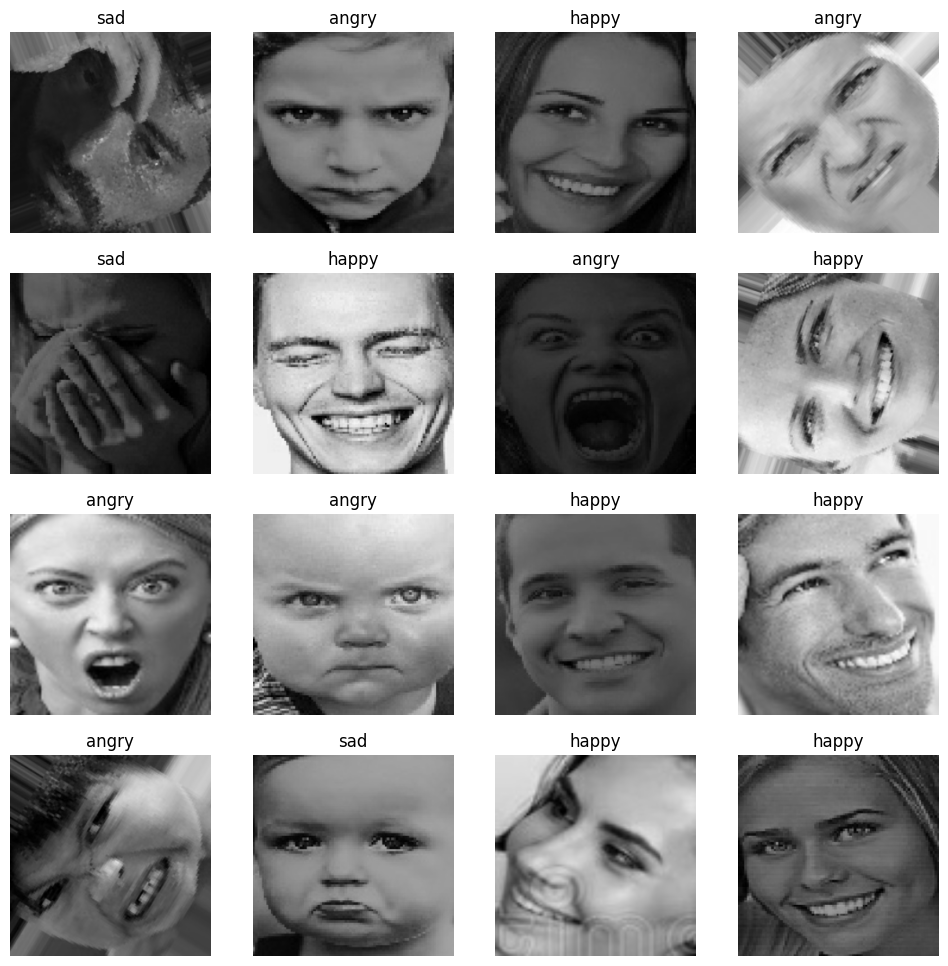

In [ ]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## Data Augmentation

In [10]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [11]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

###Cutmix Augmentation

In [12]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [13]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [14]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [15]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)
)

In [16]:
validation_dataset = (
    val_dataset
    #.prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

In [ ]:
training_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## TFRecords

In [ ]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
# val_dataset = (
#     validation_dataset
#     .unbatch()
# )

In [ ]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
#val_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[tf.argmax(label)]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
# Write the records to a file.
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range((NUM_SHARDS))])

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Modeling

## Lenet

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

## ResNet34

### CustomConv2D

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

### Residual Block

In [ ]:
n_strides = 1
dotted = (n_strides != 1)
print(dotted)

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

### Complete Network

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

## Transfer Learning with EfficientNet

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                        

## FineTunning EficientNet

In [ ]:
backbone.trainable = True

In [ ]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

In [ ]:
finetuned_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_9  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 1024)              1836032   
                                                                 
 batch_normalization_9 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                           

## Vision Transformers

### Patch Encoder

In [18]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/140808.jpg_brightness_2.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [24]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                                   sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                                   strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')

In [25]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


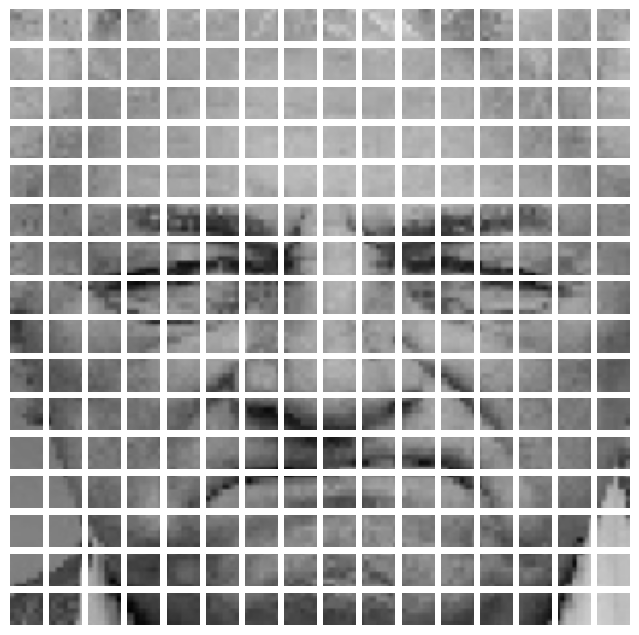

In [26]:
plt.figure(figsize = (8, 8))

for i in range(patches.shape[1]):


    ax = plt.subplot(16, 16, i+1)
    plt.imshow(tf.reshape(patches[0, i, :], (16, 16, 3)))
    plt.axis("off")

In [99]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

In [100]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(256, 768))
input_array = np.random.randint(1000, size=(1, 256))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)

1/1 [==============================] - 0s 72ms/step
(1, 256, 768)


In [101]:
from keras.src.layers.attention.multi_head_attention import MultiHeadAttention
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

In [102]:
trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1, 256, 768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [103]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [104]:
vit = ViT(N_HEADS=4, HIDDEN_SIZE=768, N_PATCHES=256, N_LAYERS=2, N_DENSE_UNITS=128)
vit(tf.zeros([32, 256, 256, 3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
       [0.46278533, 0.27631134, 0.26090336],
      

In [105]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_109 (Dense)           multiple                  25165952  
                                                                 
 dense_110 (Dense)           multiple                  16512     
                                                

## Training

In [ ]:
n_sample_0 = 1525 # angry
n_sample_1 = 3019 # happy
n_sample_2 = 2255 # sad

In [ ]:
class_weights = {0:6799/n_sample_0, 1: 6799/n_sample_1, 2: 6799/n_sample_2}

In [ ]:
print(class_weights)

In [118]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k = 2, name="top_k_accuracy")] #########

In [119]:
loss_function = CategoricalCrossentropy()

#metrics = [SparseCategoricalAccuracy(name="accuracy")]

vit.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,
)

In [ ]:
history = vit.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 108s 472ms/step - loss: 840.0181 - accuracy: 0.4049 - top_k_accuracy: 0.9165 - val_loss: 22.4582 - val_accuracy: 0.5356 - val_top_k_accuracy: 0.8117
Epoch 2/20
213/213 [==============================] - 109s 509ms/step - loss: 15.7937 - accuracy: 0.4574 - top_k_accuracy: 0.7641 - val_loss: 15.1180 - val_accuracy: 0.5285 - val_top_k_accuracy: 0.7827
Epoch 3/20
213/213 [==============================] - 109s 511ms/step - loss: 7.8636 - accuracy: 0.4861 - top_k_accuracy: 0.7863 - val_loss: 7.1027 - val_accuracy: 0.5263 - val_top_k_accuracy: 0.8200
Epoch 4/20
213/213 [==============================] - 107s 501ms/step - loss: 1223.8917 - accuracy: 0.4129 - top_k_accuracy: 0.8212 - val_loss: 1.5909 - val_accuracy: 0.4421 - val_top_k_accuracy: 0.7739
Epoch 5/20
213/213 [==============================] - 91s 423ms/step - loss: 1.0980 - accuracy: 0.4445 - top_k_accuracy: 0.7757 - val_loss: 1.0632 - val_accuracy: 0.4416 - val_top_k_accuracy: 

-------------------------------------------

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor = 'val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,
)

In [ ]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k = 2, name="top_k_accuracy")]

In [ ]:
pretrained_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = pretrained_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
    class_weight = class_weights,
    #callbacks = [checkpoint_callback]
)

Epoch 1/20
213/213 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.5804 - top_k_accuracy: 0.8279
Epoch 1: val_accuracy did not improve from 0.75066
213/213 [==============================] - 261s 908ms/step - loss: 0.9608 - accuracy: 0.5804 - top_k_accuracy: 0.8279 - val_loss: 1.5719 - val_accuracy: 0.3323 - val_top_k_accuracy: 0.5584
Epoch 2/20
213/213 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.6276 - top_k_accuracy: 0.8581
Epoch 2: val_accuracy did not improve from 0.75066
213/213 [==============================] - 183s 853ms/step - loss: 0.8311 - accuracy: 0.6276 - top_k_accuracy: 0.8581 - val_loss: 4.8131 - val_accuracy: 0.3323 - val_top_k_accuracy: 0.5584
Epoch 3/20
213/213 [==============================] - ETA: 0s - loss: 0.7653 - accuracy: 0.6611 - top_k_accuracy: 0.8806
Epoch 3: val_accuracy did not improve from 0.75066
213/213 [==============================] - 183s 852ms/step - loss: 0.7653 - accuracy: 0.6611 - top_k_accur

KeyboardInterrupt: ignored

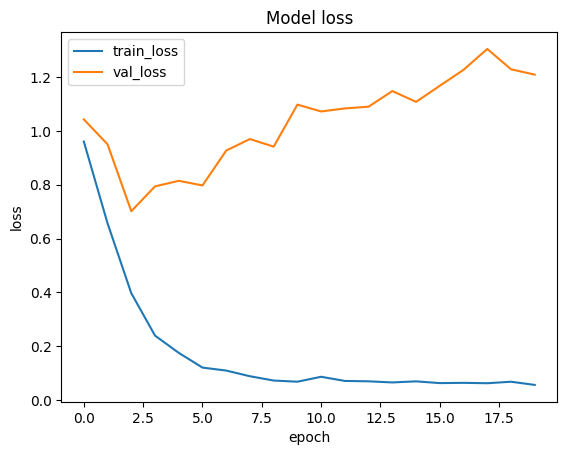

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

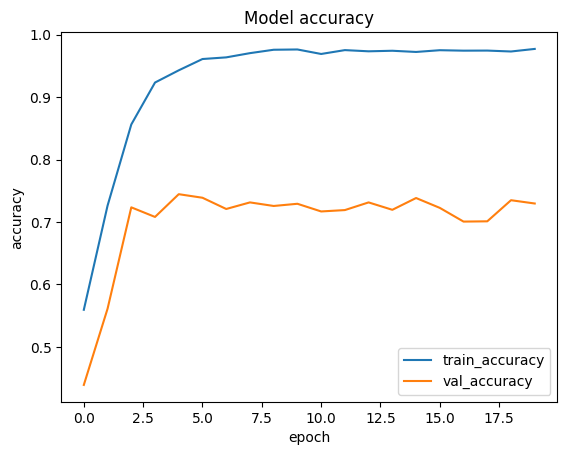

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
pretrained_model.save("/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5")

## Ensembling

In [ ]:
inputs = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

y_1 = resnet_34(inputs)
y_2 = pretrained_model(inputs)

output = 0.5*y_1 + 0.5*y_2
ensemble_model = Model(inputs = inputs, outputs = output )

## Evaluation

In [ ]:
pretrained_model.load_weights('best_weights')

In [ ]:
pretrained_model.evaluate(validation_dataset)

72/72 [==============================] - 3s 33ms/step - loss: 1.1762 - accuracy: 0.7278 - top_k_accuracy: 0.8885


[1.1761564016342163, 0.7278314232826233, 0.8884986639022827]

In [ ]:
ensemble_model.evaluate(validation_dataset)

## Testing

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/140808.jpg_brightness_2.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

happy


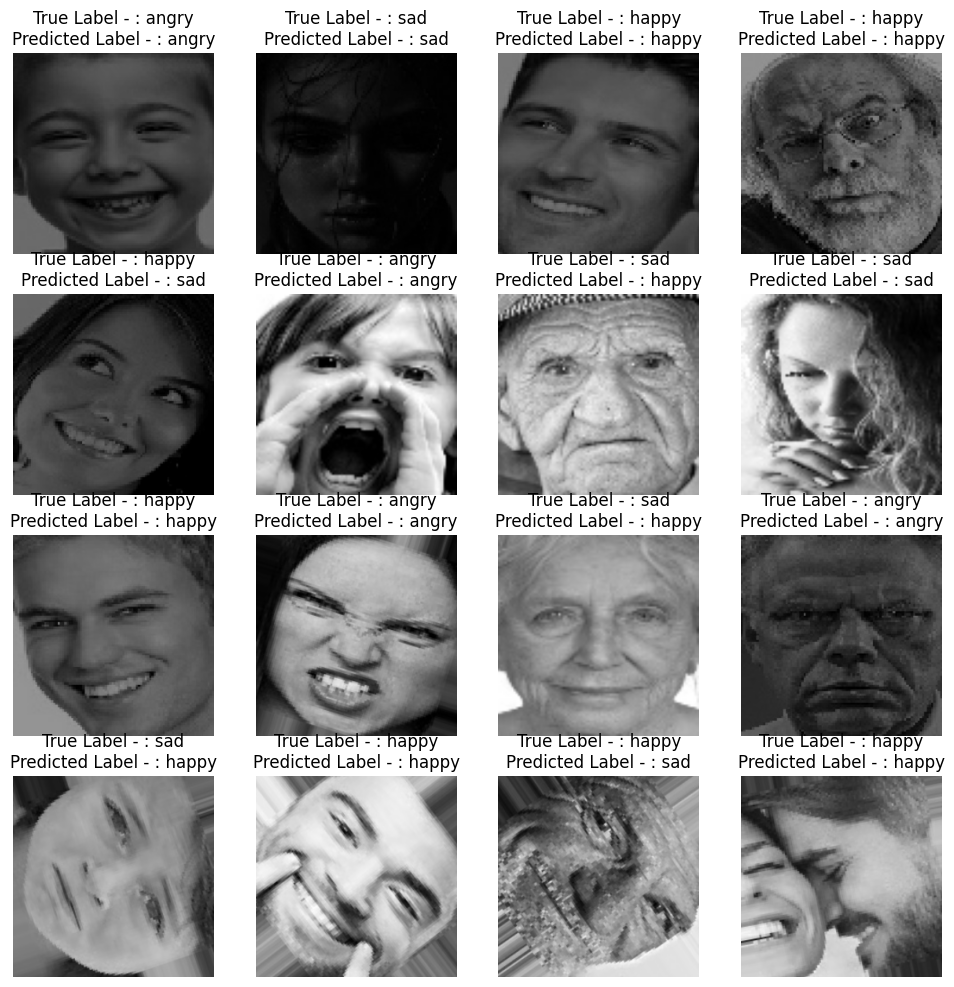

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CLASS_NAMES[int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

### Confusion Matrix

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([(np.argmax(labels[:-1], axis = -1).flatten()), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))


[1 1 1 ... 0 0 1]
[1 2 2 ... 1 1 1]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([(np.argmax(labels[:-1], axis = -1).flatten()), np.argmax(labels[-1], axis = -1).flatten()])

[[276 106 133]
 [ 45 800 161]
 [ 40 131 586]]


Text(0.5, 58.7222222222222, 'Predicted')

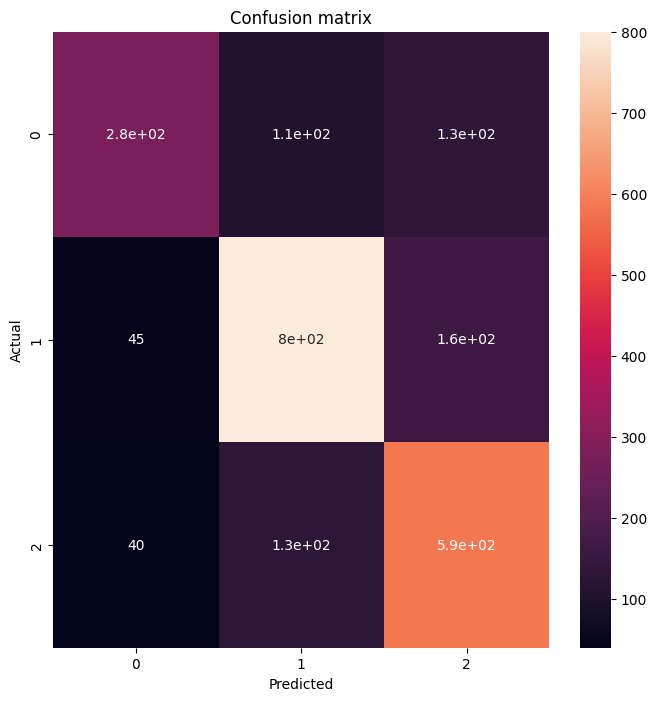

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Visualization

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
)

In [ ]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/140808.jpg_brightness_2.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 11s 11s/step


In [ ]:
print(len(f_maps))

13


In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")

## GradCam

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]']   

In [ ]:
pretrained_model.load_weights('/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5')

FileNotFoundError: ignored

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

(1, 256, 256, 3)


In [ ]:
preds = pretrained_model.predict(img_array)

In [ ]:
print(preds)

In [ ]:
np.argmax(preds[0])

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
grads.shape

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pooled_grads.shape)

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)